# Multitask Baseline Performance

In this notebook I will obtain the baseline performances obtainable using simple machine learning on the "Cookie Theft Picture Test" section of the DementiaBank dataset. <br />
The numerical features are extracted using my feature extraction project [Link here](https://github.com/EdoStoppa/Dementia_Features_Extractor). Furthermore I will define some baseline performance dropping one feature category at a time.

### Imports

In [1]:
# General import useful for each part of the notebook
import os
import re
import numpy as np
import statistics
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from typing import Tuple, Callable, Any

# Import used to manipulate all the dataset for training/testing and hyperparameters search
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Regression Models
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor

# Regression Models Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Classification Models (both Binary and Multi Class)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier

# Classification Models Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Needed to suppress some convergence warnings
from warnings import filterwarnings
filterwarnings('ignore')

# Needed to force white background to all plots
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

### Preliminary Work
This section contains some fuction and variable definition that are useful in the Notebook.<br />
Please, check all the paths and flags before executing the entire notebook.

In [2]:
# Defining some useful variables

# Set the project folder
PRJ_FOLDER = '.'
# Set the folder the full dataset is located
DATA_FOLDER = os.path.join(PRJ_FOLDER, 'data')
# Set the name of the file that holds the full dataset
FULL_DATASET_NAME = 'feature_dataset.csv'
# Set the name of the file that holds the angraphic information
ANAGRAPHIC_DATASET_NAME = 'anagraphic_info.csv'
# Create a list with all the dataset names excluding the full dataset
SEP_DATASETS_FOLDER = os.path.join(DATA_FOLDER, 'separate_datasets')
# Set the folder where all the results will be saved
RES_FOLDER = os.path.join(PRJ_FOLDER, 'results')
# Flag needed to explicit if partial datasets should be built
BUILD_PARTIAL_DATASET = True
# Flag needed to explicit if hyperparameters random search must be performed
# If false the notebook search a previously saved pickle file for the parameters
HYPER_SEARCH = False
# Flag needed to explicit if complete results must be saved
SAVE_COMPLETE_RES = False


print(f'Folder where the entire project is located: {PRJ_FOLDER}')
print(f'Folder where the full dataset is saved: {DATA_FOLDER}')
print(f'Name of the full dataset: {FULL_DATASET_NAME}')
print(f'Name of the anagraphic dataset: {ANAGRAPHIC_DATASET_NAME}')
print(f'Separate features group datasets folder: {SEP_DATASETS_FOLDER}')
print(f'Folder where all results will be saved: {RES_FOLDER}')
print(f'Flag to build partial datasets set to {BUILD_PARTIAL_DATASET}')
print(f'Flag to explicit Hyperarameter Search set to {HYPER_SEARCH}')
print(f'Flag to save extended results set to {SAVE_COMPLETE_RES}')

Folder where the entire project is located: .
Folder where the full dataset is saved: .\data
Name of the full dataset: feature_dataset.csv
Name of the anagraphic dataset: anagraphic_info.csv
Separate features group datasets folder: .\data\separate_datasets
Folder where all results will be saved: .\results
Flag to build partial datasets set to True
Flag to explicit Hyperarameter Search set to False
Flag to save extended results set to False


### Datasets Loading
In this section there are two functions used to load all the required data, and another function that is used to craft all the partial datasets.

In [3]:
# If the flag is TRUE, create all the partial datasets and save them in DATA_FOLDER

if BUILD_PARTIAL_DATASET:
    # Load the full dataset into pandas
    full_dataset = pd.read_csv(os.path.join(DATA_FOLDER, FULL_DATASET_NAME))

    for to_remove in os.listdir(SEP_DATASETS_FOLDER):
        # Avoid removing the anagraphic information
        if to_remove != ANAGRAPHIC_DATASET_NAME:
            # Get all the names of the features that should be removed
            to_remove_dataframe = pd.read_csv(os.path.join(SEP_DATASETS_FOLDER, to_remove))
            to_remove_columns = to_remove_dataframe.columns.to_list()[1:]

            # Create a partial dataset dataframe
            new_dataset = full_dataset.drop(to_remove_columns, axis=1)

            # Save the dataset
            with open(os.path.join(DATA_FOLDER, f'{to_remove.split(".")[0]}_removed.csv'), 'w+') as out:
                new_dataset.to_csv(out, index=False)

In [4]:
# Let's define a simple function that loads a single dataset

def load_raw_data(csv_path: str, feat_to_predict: str) -> Tuple[np.ndarray, np.ndarray, list]:
    # Load the entire csv file
    data = pd.read_csv(csv_path)

    # Get only the labels
    labels = pd.DataFrame(data[feat_to_predict], columns=[feat_to_predict])

    # Remove the unnecessary columns
    data = data.drop(['id', 'mmse', 'bin_class', 'multi_class3', 'multi_class4', 'multi_class5'], axis=1)

    return data.to_numpy(), labels.to_numpy().reshape((len(labels), )), data.columns.to_list()

In [5]:
# This function loads all datasets, and make them ready for training/testing

def load_processed_data(sep_data_folder: str, data_folder: str, feat_to_predict: str, num_folds: int):
    DATASETS = []
    FOLDS = []
    COLUMNS = []

    # Get the name of the folder containing the partial datasets
    name_sep_folder = sep_data_folder.split(os.path.sep)[-1]
    # Get the name of all datasets present
    DATASETS_NAMES = [dataset for dataset in os.listdir(data_folder) if dataset != name_sep_folder]
    DATASETS_NAMES.remove(FULL_DATASET_NAME)
    DATASETS_NAMES = [FULL_DATASET_NAME] + DATASETS_NAMES

    # Load every dataset 
    for name in DATASETS_NAMES:
        print(f'Loading {name}')
        # Get the raw data
        data, labels, cols = load_raw_data(os.path.join(data_folder, name), feat_to_predict)
        # Create the iterator responsible of dividing the dataset to do KFold cross validation
        kfold = StratifiedKFold(n_splits=num_folds)
        # Divide the data in training and test set
        folds = []
        for train_index, test_index in kfold.split(data, labels):
            folds.append((train_index, test_index))
        
        DATASETS.append((data, labels))
        FOLDS.append(folds)
        COLUMNS.append(cols)

    # Remove suffix from dataset names
    DATASETS_NAMES = ['All Features'] + list(map(lambda x: re.sub('\.csv$', '', x), DATASETS_NAMES))[1:]
    print(DATASETS_NAMES)
    
    print('\nAll data loaded!')
    return DATASETS_NAMES, DATASETS, COLUMNS, FOLDS

## Training Functions

In [6]:
def hyper_grid_search(X, y, models: list, spaces: list, scoring: str, num_jobs=-1) -> list:
    # Get the cross validator
    cv = StratifiedKFold(n_splits=5)

    # Perform the Hyperparameter Grid Search
    final_parameters = {}
    for (model, name), space in zip(models, spaces):
        print(f'Searching {name} hyperparameters space...')
        # Create the GridSearch object
        search = GridSearchCV(model, space, scoring=scoring, n_jobs=num_jobs, cv=cv)
        # Perform the seach
        search = search.fit(X, y)
        # Save and display the results
        final_parameters[name] = search.best_params_
        print('Best parameters: ', search.best_params_, '\n')

    print('\nEverything complete!')
    return final_parameters

In [7]:
# Function used to train both the regression and classification models

def train_models(models_generator: Callable[[], Any], datasets: list, datasets_names: list, kfolds: list, model_params: list) -> list:
    ready_models = []
    for data, data_name, folds in zip(datasets, datasets_names, kfolds):
        print(f'Working on {data_name}')

        # Unwrap data
        dataset, label = data
        
        # Train a model for each fold
        trained_folds = []
        for fold in folds:
            train_index, _ = fold
            X_train, y_train = dataset[train_index], label[train_index]

            # Generate new batch of models
            models = models_generator()
            
            fold_models = []
            for model, model_name in models:
                # Set the parameters of the model
                model.set_params(**model_params[model_name])
                # Train model
                model.fit(X_train, y_train)
                # Save model
                fold_models.append((model_name, model))

            # Save all trained models for the fold
            trained_folds.append(fold_models)

        # Save all the trained fold models for the daaset
        ready_models.append(trained_folds)

    print('\nEverything complete!')
    return ready_models

## Evaluation Functions

In [8]:
def plot_results(lbls: list, avgs: dict, stdevs: dict, y_name: str, title: str, dimensions: tuple, precision=1.0):
    # Fix figure dimensions
    plt.rcParams["figure.figsize"] = dimensions

    # Extract the max value on the Y axis
    max_avg_y = max([max(item) for _, item in avgs.items()])
    max_stdev_y = max([max(item) for _, item in stdevs.items()])
    max_y = np.ceil(max_avg_y) if max_avg_y + max_stdev_y < np.ceil(max_avg_y) else np.ceil(max_avg_y + max_stdev_y)

    # Format the data in order to be fed to Pandas
    algos = [key for key, _ in avgs.items()]

    avgs = [item for _, item in avgs.items()]
    avgs = list(map(list, zip(*avgs)))

    stdevs = [item for _, item in stdevs.items()]
    stdevs = list(map(list, zip(*stdevs)))

    # Create positions of the bars
    w = 0.12
    xticks = [np.arange(len(avgs[0]))]
    for _ in range(1, len(avgs)):
        xticks.append(xticks[-1] + w)

    # Actually plot everything
    for values, stdev, pos, lbl in zip(avgs, stdevs, xticks, lbls):
        plt.bar(pos, values, w, label=lbl)
        plt.errorbar(pos, values, yerr=stdev, fmt="o", ecolor='black', capsize=3, color='black')

    # Choose the right position to put the labels on
    num_datasets = len(avgs)
    if num_datasets % 2 == 0:
        idx = num_datasets//2 - 1
        pos = xticks[idx] + w/2
    else:
        idx = (num_datasets - 1) // 2
        pos = xticks[idx]

    for idx in range(len(algos)):
        if len(algos[idx]) >= 14:
            temp = algos[idx].split(' ')
            idx_split = int(np.ceil(len(temp / 2.0)))
            algos[idx] = temp[:idx_split].join(' ') + '\n' +  temp[idx_split:].join(' ')
            break
    
    # Fix tile and y/x labels
    SMALL_SIZE = 22
    MEDIUM_SIZE = 26
    BIGGER_SIZE = 38
    plt.title(title, fontsize=BIGGER_SIZE)
    plt.ylabel(y_name, fontsize=MEDIUM_SIZE)
    plt.xlabel('Model', fontsize=MEDIUM_SIZE)
    plt.xticks(pos, algos, rotation = 20, fontsize=SMALL_SIZE)
    plt.yticks(np.arange(0, max_y, precision), fontsize=SMALL_SIZE)
    # Finish everything and show it
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.show()
    

In [9]:
# Function used to evaluate the regression models

def evaluate_regression_models(ready_models: list, datasets: list, datasets_names: list, kfolds: list) -> list:
    evaluation_results = []
    avg_to_plot = {name[0]: [] for name in ready_models[0][0]}
    std_to_plot = {name[0]: [] for name in ready_models[0][0]}
    
    for kmodels_matrix, folds, data, name in zip(ready_models, kfolds, datasets, datasets_names):
        # Preprocess the name removing the file extension
        name = name.split('.')[0]
        # Unwrap data
        dataset, label = data
        
        # Reorganize the models
        kmodels_matrix = list(map(list, zip(*kmodels_matrix)))
        out = ''
        for models_list in kmodels_matrix:            
            mae, rmse, r2 = [], [], []
            for (model_name, model), fold in zip(models_list, folds):
                _, test_index = fold
                X_test, y_test = dataset[test_index], label[test_index]
                # Compute the predictions for the test dataset
                predictions = model.predict(X_test)

                mae.append(mean_absolute_error(y_test, predictions))
                rmse.append(np.sqrt(mean_squared_error(y_test, predictions)))
                r2.append(r2_score(y_test, predictions))
            
            # Compute the average and standard deviation of each metric
            mae_avg, mae_std = statistics.mean(mae), statistics.stdev(mae)
            rmse_avg, rmse_std = statistics.mean(rmse), statistics.stdev(rmse)
            r2_avg, r2_std = statistics.mean(r2), statistics.stdev(r2)

            # Save data in dictionary ready to be plotted
            avg_to_plot[model_name].append(rmse_avg)
            std_to_plot[model_name].append(rmse_std)

            # Compute all the interesting metrics
            out += f'{model_name}\n\n'
            out += f'MAE                \tAvg: {mae_avg:.3f}\tStdDev: {mae_std:.3f}\n'
            out += f'RMSE               \tAvg: {rmse_avg:.3f}\tStdDev: {rmse_std:.3f}\n'
            out += f'R2                 \tAvg: {r2_avg:.3f}\tStdDev: {r2_std:.3f}\n'
            out += '\n****************************************************************\n\n'

        evaluation_results.append((name, out))

    plot_results(datasets_names, avg_to_plot, std_to_plot, 'RMSE', 'Regression Performance', (15,9), precision=0.5)
    
    return evaluation_results

In [10]:
# Fucntion that compute the metrics for the binary classification task
def compute_metrics_bin(true: np.ndarray, pred: np.ndarray, lbls: list):
    acc  = accuracy_score(true, pred)
    prec = precision_score(true, pred)
    rec  = recall_score(true, pred)
    f1   = f1_score(true, pred)

    return acc, prec, rec, f1

In [11]:
# Fucntion that compute the metrics for the multiclass classification task
def compute_metrics_multi(true: np.ndarray, pred: np.ndarray, lbls: list):
    # Generate a list of int representing all the available classes
    classes = np.arange(0, len(np.bincount(lbls)), 1)
    # Compute the confusion matrix
    mtx = confusion_matrix(true, pred, labels=classes
    )
    # Compute the total accuracy
    acc = sum([mtx[i, i] for i in classes]) / np.sum(mtx)

    # Compute the list of precision, recall, and f1 score for each class
    precs, recs, f1s = [], [], [] 
    for idx in classes:
        sum_prec = np.sum(mtx[:, idx])
        precs.append(mtx[idx, idx] / sum_prec if sum_prec > 0 else 0)

        sum_rec = np.sum(mtx[idx, :])
        recs.append(mtx[idx, idx] / sum_rec if sum_rec > 0 else 0)
        
        nan_flag = precs[-1]==0 and recs[-1]==0
        new_f1 = 0 if nan_flag else 2 * (precs[-1] * recs[-1]) / (precs[-1] + recs[-1])
        f1s.append(new_f1)

    # Extract the final score (uin the macro-average)
    tot_prec = np.average(precs)
    tot_rec = np.average(recs)
    tot_f1 = np.average(f1s)

    return acc, tot_prec, tot_rec, tot_f1


In [12]:
# Function used to evaluate the classification models

def evaluate_classification_models(ready_models: list, datasets: list, datasets_names: list, kfolds: list, typ: str, compute_metr) -> list:
    evaluation_results = []
    avg_to_plot = {name[0]: [] for name in ready_models[0][0]}
    std_to_plot = {name[0]: [] for name in ready_models[0][0]}
    
    for kmodels_matrix, folds, data, name in zip(ready_models, kfolds, datasets, datasets_names):
        # Preprocess the name removing the file extension
        name = name.split('.')[0]
        # Unwrap data
        dataset, label = data
        
        # Reorganize the models
        kmodels_matrix = list(map(list, zip(*kmodels_matrix)))
        out = ''
        for models_list in kmodels_matrix:
                       
            acc, prec, rec, f1 = [], [], [], []
            for (model_name, model), fold in zip(models_list, folds):
                _, test_index = fold
                X_test, y_test = dataset[test_index], label[test_index]
                # Compute the predictions for the test dataset
                predictions = model.predict(X_test)

                metrics = compute_metr(y_test, predictions, label)
                acc.append(metrics[0])
                prec.append(metrics[1])
                rec.append(metrics[2])
                f1.append(metrics[3])
                
            # Compute the average and standard deviation of each metric
            acc_avg, acc_std = statistics.mean(acc), statistics.stdev(acc)
            prec_avg, prec_std = statistics.mean(prec), statistics.stdev(prec)
            rec_avg, rec_std = statistics.mean(rec), statistics.stdev(rec)
            f1_avg, f1_std = statistics.mean(f1), statistics.stdev(f1)

            # Save data in dictionary ready to be plotted
            avg_to_plot[model_name].append(acc_avg)
            std_to_plot[model_name].append(acc_std)

            # Compute all the interesting metrics
            
            out += f'{model_name}\n\n'
            out += f'Accuracy:          \tAvg: {acc_avg:.3f}\tStdDev: {acc_std:.3f}\n'
            out += f'Precision:         \tAvg: {prec_avg:.3f}\tStdDev: {prec_std:.3f}\n'
            out += f'Recall:            \tAvg: {rec_avg:.3f}\tStdDev: {rec_std:.3f}\n'
            out += f'F1:                \tAvg: {f1_avg:.3f}\tStdDev: {f1_std:.3f}\n'
            out += '\n**********************************************\n\n'

        evaluation_results.append((name, out))

    plot_results(datasets_names, avg_to_plot, std_to_plot, 'Accuracy', f'{typ} Classification Performance', (15,9), precision=0.1)
    
    return evaluation_results
    

In [13]:
# Function used to save the results in the correct files

def save_results(results: list, save_folder: str, task: str):
    for name, out in results:
        with open(os.path.join(save_folder, task, name + '.txt'), 'w+') as file:
            file.write(out)


## Regression
In this section we are going to evalute the performance of different regression models.<br />
In particular, we're going to predict the MMSE score of each conversation using these models:
- Ridge Regression
- KNN Regressor
- Boosted Trees
- Bagged Trees
- Decision Tree
- Support Vector Machine Regressor

In [14]:
# Let's set some important variables first

FEATURE_TO_PREDICT = 'mmse'
NUM_FOLDS = 5
TYPE = 'regression'

In [15]:
# A simple function that generates a fresh batch of regression models ready to be trained

def get_regression_models() -> list:
    models = [(Ridge(), 'Ridge Regression'), (KNeighborsRegressor(), 'KNN Regressor'),
              (GradientBoostingRegressor(), 'Boosted Trees'), (BaggingRegressor(), 'Bagged Trees'), 
              (DecisionTreeRegressor(), 'Decision Tree'), (LinearSVR(), 'SVM')]

    return models

In [16]:
# A simple function that returns a list of dictionaries containing the hyperparameters state space of each model

def get_regression_hyper_space():
    search_spaces = [
        # Ridge
        {'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
        'fit_intercept': [True, False],
        'normalize': [True, False],
        'max_iter': [1000, 5000, 10000],
        'solver': ['svd', 'cholesky', 'lsqr', 'lbfgs']},
        # K-Neighbor
        {'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'p': [1, 2]},
        # Gradient Boosting
        {'loss': ['ls', 'lad', 'huber'],
        'learning_rate': [0.01, 0.01, 0.1, 1],
        'n_estimators': [50, 100, 150, 200],
        'criterion': ['friedman_mse', 'squared_error', 'mae'],
        'max_depth': [3, 5, 7],
        'max_features': ['auto', 'sqrt', 'log2']},
        # Bagging
        {'n_estimators': [10, 50, 100, 200],
        'max_features': [1, 4, 8, 16, 32],
        'bootstrap': [True, False],
        'bootstrap_features': [True, False],
        'oob_score': [True, False],},
        # Decision trees
        {'criterion': ['friedman_mse', 'squared_error', 'absolute_error', 'poisson'],
        'max_depth': [1, 3, 5, 7, None],
        'splitter': ['best', 'random'],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_leaf_nodes': [None, 2, 4, 8, 16]},
        # SVM
        {'tol': [1e-5, 1e-4, 1e-3, 1e-2],
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
        'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
        'fit_intercept': [True, False],
        'max_iter': [1000, 5000, 10000]}
    ]

    return search_spaces

In [17]:
# Get the hyperparameters for each model

if HYPER_SEARCH:
    # Get the full dataset
    X, y, cols = load_raw_data(os.path.join(DATA_FOLDER, FULL_DATASET_NAME), FEATURE_TO_PREDICT)
    # Perform the search
    PARAMS = hyper_grid_search(X, y, get_regression_models(), get_regression_hyper_space(), 'neg_root_mean_squared_error')
    # Save the parameters
    with open(os.path.join(RES_FOLDER, TYPE, 'params.pickle'), 'wb') as f:
        pickle.dump(PARAMS, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(os.path.join(RES_FOLDER, TYPE, 'params.pickle'), 'rb') as f:
        PARAMS = pickle.load(f)


In [18]:
# Loading the datasets and preparing them for training & testing
DATASETS_NAMES, DATASETS, COLUMNS, FOLDS = load_processed_data(SEP_DATASETS_FOLDER, DATA_FOLDER, FEATURE_TO_PREDICT, NUM_FOLDS)

Loading feature_dataset.csv
Loading acoustic_info_removed.csv
Loading discourse_info_removed.csv
Loading lexicosyntactic_info_removed.csv
Loading psycholinguistic_info_removed.csv
Loading spatial_info_removed.csv
['All Features', 'acoustic_info_removed', 'discourse_info_removed', 'lexicosyntactic_info_removed', 'psycholinguistic_info_removed', 'spatial_info_removed']

All data loaded!


In [19]:
# Train all these regression models
trained_regression_models = train_models(get_regression_models, DATASETS, DATASETS_NAMES, FOLDS, PARAMS)

Working on All Features
Working on acoustic_info_removed
Working on discourse_info_removed
Working on lexicosyntactic_info_removed
Working on psycholinguistic_info_removed
Working on spatial_info_removed

Everything complete!


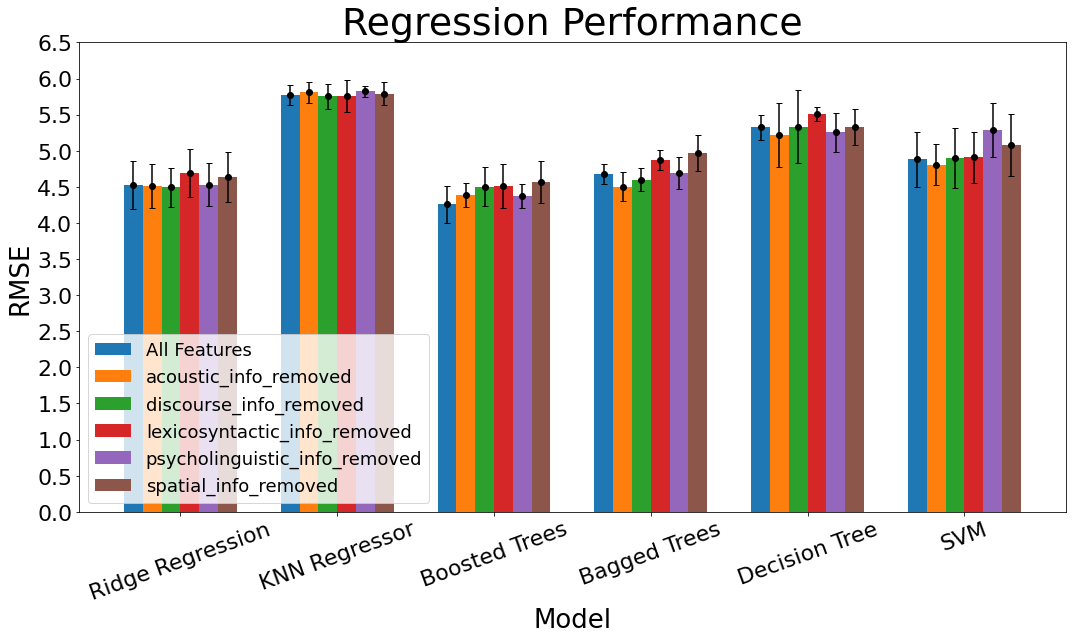

In [20]:
# Evaluate all the models
regression_results = evaluate_regression_models(trained_regression_models, DATASETS, DATASETS_NAMES, FOLDS)

if SAVE_COMPLETE_RES:
    # Save the results to different files
    save_results(regression_results, RES_FOLDER, TYPE)

## Binary Classification
In this section we are going to evaluate multiple classification models.<br />
In particular, we are going to predict if each conversation was made by a patient with Dementia or by a control patient. We will use these models:
- Decision Tree
- Linear Discriminant Classifier
- Logistic Regression
- Gaussian Naive Bayes
- Linear Support Vector Classifier
- K-Nearest Neighbors Classifier
- Boosted Trees
- Bagged Trees

In [21]:
# Let's set some important variables first

FEATURE_TO_PREDICT = 'bin_class'
NUM_FOLDS = 5
TYPE = 'binary_classification'

In [22]:
# A simple function that generates a fresh batch of binary classification models ready to be trained

def get_binary_class_models() -> list:
    models = [(LogisticRegression(), 'Logistic Regression'), (GaussianNB(), 'Gaussian Naive Bayes'),
              (LinearSVC(), 'Linear Support Vector Classifier'), (KNeighborsClassifier(), 'KNN Classifier'),
              (GradientBoostingClassifier(), 'Boosted Trees'), (BaggingClassifier(), 'Bagged Trees')]
    return models

In [23]:
# A simple function that returns a list of dictionaries containing the hyperparameters state space of each model

def get_bin_hyper_space():
    search_spaces = [
        # Logistic Regression
        {'penalty': ['l1', 'l2', 'none', 'elasticnet'],
        'tol': [1e-5, 1e-4, 1e-3, 1e-2],
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
        'fit_intercept': [True, False],
        'max_iter': [100, 250, 500],
        'solver': ['newton-cg', 'saga', 'sag', 'liblinear', 'lbfgs']},
        # Gaussian Naive Bayes
        {'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]},
        # SVM
        {'penalty': ['l1', 'l2'],
        'tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-4, 1e-3],
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
        'loss': ['hinge', 'squared_hinge'],
        'fit_intercept': [True, False],
        'max_iter': [1000, 5000, 10000]},
        # K Neighbors
        {'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'p': [1, 2]},
        # Gradient Boosting
        {'loss': ['deviance', 'exponential'],
        'learning_rate': [0.001, 0.01, 0.1, 1],
        'n_estimators': [10, 50, 100, 200],
        'criterion': ['friedman_mse', 'squared_error', 'mae'],
        'max_depth': [1, 3, 5, 7],
        'max_features': ['auto', 'sqrt', 'log2']},
        # Bagging
        {'n_estimators': [5, 10, 50, 100, 200],
        'max_features': [1, 4, 8, 16, 32],
        'bootstrap': [True, False],
        'bootstrap_features': [True, False],
        'oob_score': [True, False]}        
    ]

    return search_spaces

In [24]:
# Get the hyperparameters for each model

if HYPER_SEARCH:
    # Get the full dataset data
    X, y, cols = load_raw_data(os.path.join(DATA_FOLDER, FULL_DATASET_NAME), FEATURE_TO_PREDICT)
    # Perform the search
    PARAMS = hyper_grid_search(X, y, get_binary_class_models(), get_bin_hyper_space(), 'accuracy')
    # Save the found parameters
    with open(os.path.join(RES_FOLDER, TYPE, 'params.pickle'), 'wb') as f:
        pickle.dump(PARAMS, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(os.path.join(RES_FOLDER, TYPE, 'params.pickle'), 'rb') as f:
        PARAMS = pickle.load(f)

In [25]:
# Loading the datasets and preparing them for training & testing
DATASETS_NAMES, DATASETS, COLUMNS, FOLDS = load_processed_data(SEP_DATASETS_FOLDER, DATA_FOLDER, FEATURE_TO_PREDICT, NUM_FOLDS)

Loading feature_dataset.csv
Loading acoustic_info_removed.csv
Loading discourse_info_removed.csv
Loading lexicosyntactic_info_removed.csv
Loading psycholinguistic_info_removed.csv
Loading spatial_info_removed.csv
['All Features', 'acoustic_info_removed', 'discourse_info_removed', 'lexicosyntactic_info_removed', 'psycholinguistic_info_removed', 'spatial_info_removed']

All data loaded!


In [26]:
# Train all the models
trained_binary_class_models = train_models(get_binary_class_models, DATASETS, DATASETS_NAMES, FOLDS, PARAMS)

Working on All Features
Working on acoustic_info_removed
Working on discourse_info_removed
Working on lexicosyntactic_info_removed
Working on psycholinguistic_info_removed
Working on spatial_info_removed

Everything complete!


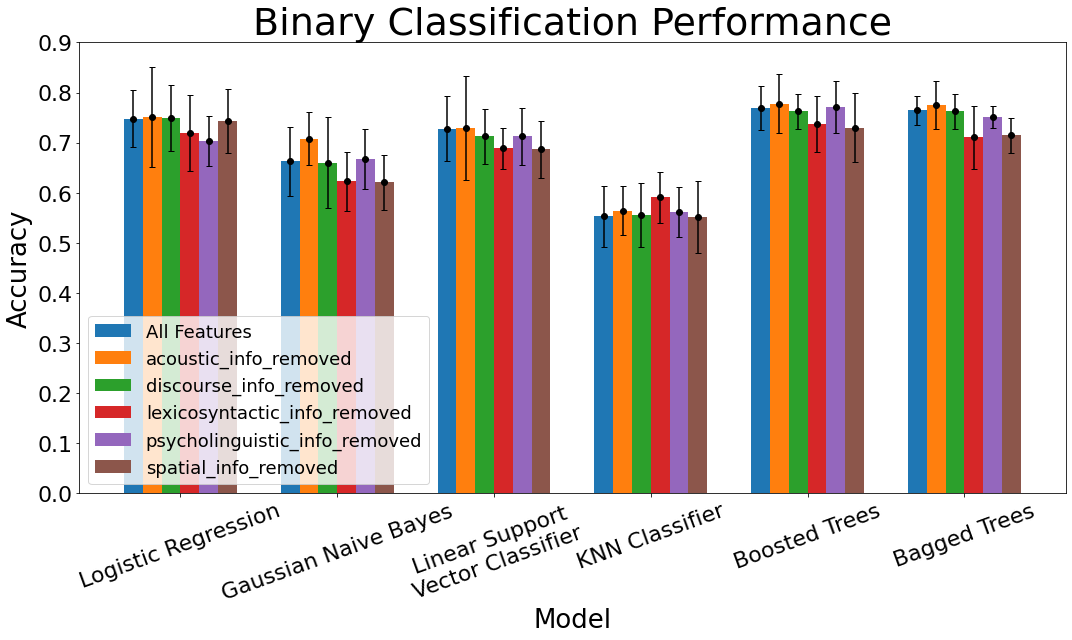

In [27]:
# Evaluate all the models
bin_class_results = evaluate_classification_models(trained_binary_class_models, DATASETS, DATASETS_NAMES, FOLDS, 'Binary', compute_metrics_bin)

if SAVE_COMPLETE_RES:
    # Save the results to different files
    save_results(bin_class_results, RES_FOLDER, TYPE)

## Multiclass Classification
In this section we introduce a new task: Multi Class classification.<br />
We have different version of these multi class labels because there no a single multi label system present in the medical literature. Thus, we create 3 possible version of the labeling that will be examined.

In [28]:
# A simple function that generates a fresh batch of binary classification models ready to be trained

def get_multi_class_models() -> list:
    models =[(LogisticRegression(), 'Logistic Regression'), (GaussianNB(), 'Gaussian Naive Bayes'),
              (LinearSVC(), 'Linear Support Vector Classifier'), (KNeighborsClassifier(), 'KNN Classifier'),
              (GradientBoostingClassifier(), 'Boosted Trees'), (BaggingClassifier(), 'Bagged Trees')]
    return models

In [29]:
# A simple function that returns a list of dictionaries containing the hyperparameters state space of each model

def get_multi_hyper_space():
    # I use the same beacuse in my case there's no difference in the models used for binary and multiclass classification
    return get_multi_hyper_space()

### 3 Classes
- mmse >= 24 --> No Dementia
- 18 <= mmse <= 23 --> Dementia
- mmse <= 17 --> Severe Dementia

In [30]:
# Let's set some important variables first

FEATURE_TO_PREDICT = 'multi_class3'
NUM_FOLDS = 5
TYPE = 'multi_classification3'

In [31]:
# Get the hyperparameters for each model

if HYPER_SEARCH:
    # Get the full dataset data
    X, y, cols = load_raw_data(os.path.join(DATA_FOLDER, FULL_DATASET_NAME), FEATURE_TO_PREDICT)
    # Perform the search
    PARAMS = hyper_grid_search(X, y, get_binary_class_models(), get_bin_hyper_space(), 'accuracy')
    # Save the found parameters
    with open(os.path.join(RES_FOLDER, TYPE, 'params.pickle'), 'wb') as f:
        pickle.dump(PARAMS, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(os.path.join(RES_FOLDER, TYPE, 'params.pickle'), 'rb') as f:
        PARAMS = pickle.load(f)

In [32]:
# Loading the datasets and preparing them for training & testing
DATASETS_NAMES, DATASETS, COLUMNS, FOLDS = load_processed_data(SEP_DATASETS_FOLDER, DATA_FOLDER, FEATURE_TO_PREDICT, NUM_FOLDS)

Loading feature_dataset.csv
Loading acoustic_info_removed.csv
Loading discourse_info_removed.csv
Loading lexicosyntactic_info_removed.csv
Loading psycholinguistic_info_removed.csv
Loading spatial_info_removed.csv
['All Features', 'acoustic_info_removed', 'discourse_info_removed', 'lexicosyntactic_info_removed', 'psycholinguistic_info_removed', 'spatial_info_removed']

All data loaded!


In [33]:
# Train all the models
trained_multi_class3_models = train_models(get_multi_class_models, DATASETS, DATASETS_NAMES, FOLDS, PARAMS)

Working on All Features
Working on acoustic_info_removed
Working on discourse_info_removed
Working on lexicosyntactic_info_removed
Working on psycholinguistic_info_removed
Working on spatial_info_removed

Everything complete!


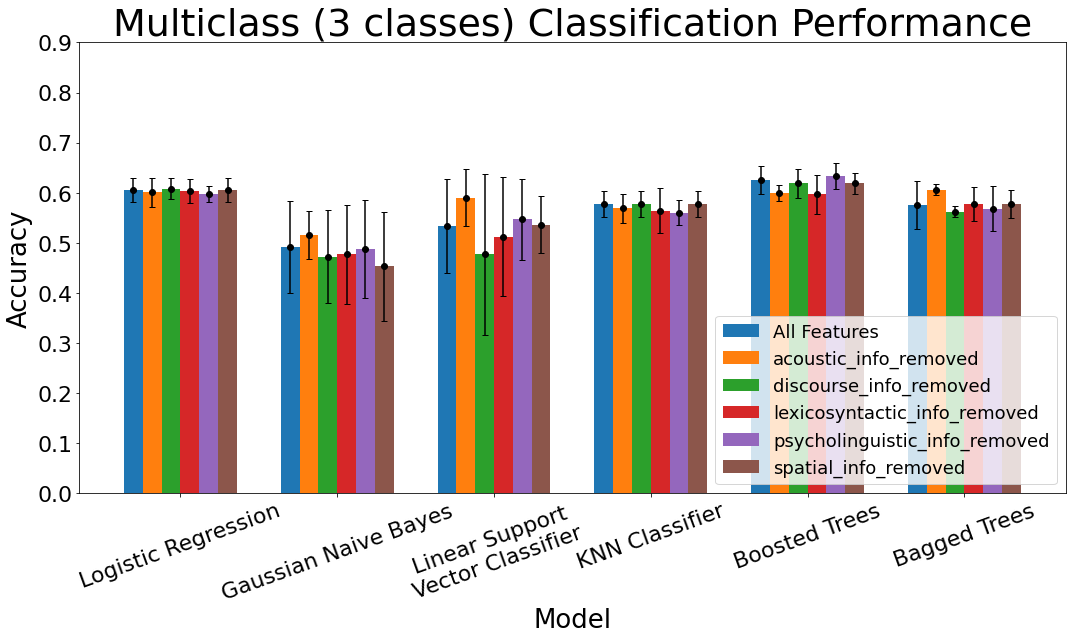

In [34]:
# Evaluate all the models
multi_class3_results = evaluate_classification_models(trained_multi_class3_models, DATASETS, DATASETS_NAMES, FOLDS, 'Multiclass (3 classes)', compute_metrics_multi)

if SAVE_COMPLETE_RES:
    # Save the results to different files
    save_results(multi_class3_results, RES_FOLDER, TYPE)

### 4 Classes
- mmse >= 26 --> No Dementia
- 19 <= mmse <= 25 --> Mild Dementia
- 10 <= mmse <= 18 --> Dementia
- mmse <= 9 --> Severe Dementia

In [35]:
# Let's set some important variables first

FEATURE_TO_PREDICT = 'multi_class4'
NUM_FOLDS = 5
TYPE = 'multi_classification4'

In [36]:
# Get the hyperparameters for each model

if HYPER_SEARCH:
    # Get the full dataset data
    X, y, cols = load_raw_data(os.path.join(DATA_FOLDER, FULL_DATASET_NAME), FEATURE_TO_PREDICT)
    # Perform the search
    PARAMS = hyper_grid_search(X, y, get_binary_class_models(), get_bin_hyper_space(), 'accuracy')
    # Save the found parameters
    with open(os.path.join(RES_FOLDER, TYPE, 'params.pickle'), 'wb') as f:
        pickle.dump(PARAMS, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(os.path.join(RES_FOLDER, TYPE, 'params.pickle'), 'rb') as f:
        PARAMS = pickle.load(f)

In [37]:
# Loading the datasets and preparing them for training & testing
DATASETS_NAMES, DATASETS, COLUMNS, FOLDS = load_processed_data(SEP_DATASETS_FOLDER, DATA_FOLDER, FEATURE_TO_PREDICT, NUM_FOLDS)

Loading feature_dataset.csv
Loading acoustic_info_removed.csv
Loading discourse_info_removed.csv
Loading lexicosyntactic_info_removed.csv
Loading psycholinguistic_info_removed.csv
Loading spatial_info_removed.csv
['All Features', 'acoustic_info_removed', 'discourse_info_removed', 'lexicosyntactic_info_removed', 'psycholinguistic_info_removed', 'spatial_info_removed']

All data loaded!


In [38]:
# Train all the models
trained_multi_class4_models = train_models(get_multi_class_models, DATASETS, DATASETS_NAMES, FOLDS, PARAMS)

Working on All Features
Working on acoustic_info_removed
Working on discourse_info_removed
Working on lexicosyntactic_info_removed
Working on psycholinguistic_info_removed
Working on spatial_info_removed

Everything complete!


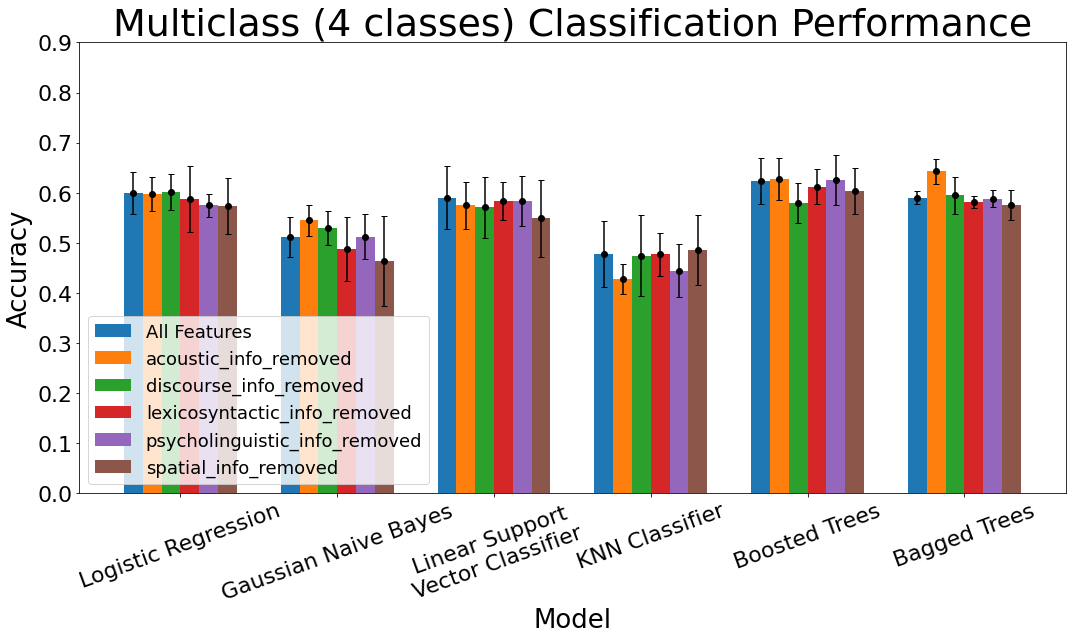

In [39]:
# Evaluate all the models
multi_class4_results = evaluate_classification_models(trained_multi_class4_models, DATASETS, DATASETS_NAMES, FOLDS, 'Multiclass (4 classes)', compute_metrics_multi)

if SAVE_COMPLETE_RES:
    # Save the results to different files
    save_results(multi_class4_results, RES_FOLDER, TYPE)

### 5 Classes
- mmse == 30 --> No Dementia
- 26 <= mmse <= 29 --> Possible Dementia
- 19 <= mmse <= 25 --> Mild Dementia
- 10 <= mmse <= 18 --> Dementia
- mmse <= 9 --> Severe Dementia

In [40]:
# Let's set some important variables first

FEATURE_TO_PREDICT = 'multi_class5'
NUM_FOLDS = 5
TYPE = 'multi_classification5'

In [41]:
# Get the hyperparameters for each model

if HYPER_SEARCH:
    # Get the full dataset data
    X, y, cols = load_raw_data(os.path.join(DATA_FOLDER, FULL_DATASET_NAME), FEATURE_TO_PREDICT)
    # Perform the search
    PARAMS = hyper_grid_search(X, y, get_binary_class_models(), get_bin_hyper_space(), 'accuracy')
    # Save the found parameters
    with open(os.path.join(RES_FOLDER, TYPE, 'params.pickle'), 'wb') as f:
        pickle.dump(PARAMS, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(os.path.join(RES_FOLDER, TYPE, 'params.pickle'), 'rb') as f:
        PARAMS = pickle.load(f)

In [42]:
# Loading the datasets and preparing them for training & testing
DATASETS_NAMES, DATASETS, COLUMNS, FOLDS = load_processed_data(SEP_DATASETS_FOLDER, DATA_FOLDER, FEATURE_TO_PREDICT, NUM_FOLDS)

Loading feature_dataset.csv
Loading acoustic_info_removed.csv
Loading discourse_info_removed.csv
Loading lexicosyntactic_info_removed.csv
Loading psycholinguistic_info_removed.csv
Loading spatial_info_removed.csv
['All Features', 'acoustic_info_removed', 'discourse_info_removed', 'lexicosyntactic_info_removed', 'psycholinguistic_info_removed', 'spatial_info_removed']

All data loaded!


In [43]:
# Train all the models
trained_multi_class5_models = train_models(get_multi_class_models, DATASETS, DATASETS_NAMES, FOLDS, PARAMS)

Working on All Features
Working on acoustic_info_removed
Working on discourse_info_removed
Working on lexicosyntactic_info_removed
Working on psycholinguistic_info_removed
Working on spatial_info_removed

Everything complete!


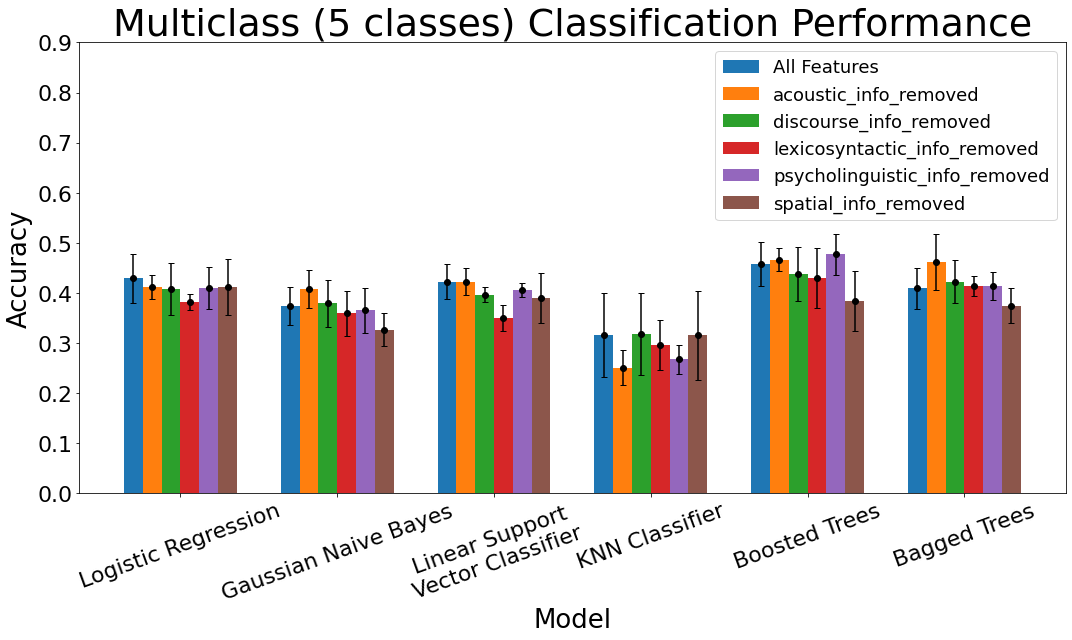

In [44]:
# Evaluate all the models
multi_class5_results = evaluate_classification_models(trained_multi_class5_models, DATASETS, DATASETS_NAMES, FOLDS, 'Multiclass (5 classes)', compute_metrics_multi)

if SAVE_COMPLETE_RES:
    # Save the results to different files
    save_results(multi_class5_results, RES_FOLDER, TYPE)